1. Данных для анализа очень много на сайте для соревнований по машинному обучению [kaggle](https://www.kaggle.com/). Мы возьмем исторические данные по [биткоину](https://www.kaggle.com/mczielinski/bitcoin-historical-data) и посмотрим, какую информацию можно извлечь из него, какие статистики посчитать и какой анализ провести. 

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')


BTC_USD = "18Nvsd-tAoF-FVkXZcKX07Bhagxeteawx" #@param {type:"string"}

BTC_USD_file = drive.CreateFile({'id': BTC_USD }) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(BTC_USD_file['title'])  
BTC_USD_file.GetContentFile(BTC_USD_file['title'])  # Save Drive file as a local file

USD_RUB = '1AEv6opCrO240Zv--_FCtbmJ_sWNOHxJs'
USD_RUB_file = drive.CreateFile({'id': USD_RUB }) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(USD_RUB_file['title'])  
USD_RUB_file.GetContentFile(USD_RUB_file['title'])  # Save Drive file as a local file


!unzip {USD_RUB_file['title']}

bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv
Archive.zip
Archive:  Archive.zip
  inflating: USDRUB_110101_111231.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._USDRUB_110101_111231.csv  
  inflating: USDRUB_130101_131231.csv  
  inflating: __MACOSX/._USDRUB_130101_131231.csv  
  inflating: USDRUB_120101_121231.csv  
  inflating: __MACOSX/._USDRUB_120101_121231.csv  
  inflating: USDRUB_180101_181231.csv  
  inflating: __MACOSX/._USDRUB_180101_181231.csv  
  inflating: USDRUB_170101_171231.csv  
  inflating: __MACOSX/._USDRUB_170101_171231.csv  
  inflating: USDRUB_160101_161231.csv  
  inflating: __MACOSX/._USDRUB_160101_161231.csv  
  inflating: USDRUB_150101_151231.csv  
  inflating: __MACOSX/._USDRUB_150101_151231.csv  
  inflating: USDRUB_140101_141231.csv  
  inflating: __MACOSX/._USDRUB_140101_141231.csv  
  inflating: USDRUB_190101_190812.csv  
  inflating: __MACOSX/._USDRUB_190101_190812.csv  


Теперь данные загружены в память Colab и с ними можно работать.

Импортируем все библиотеки для анализа файла:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

plt.style.use('dark_background')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Прочитаем файл и посмотрим, что за данные там расположены:

* Timestamp - время сделки в особом формате
* Open - цена открытия
* High - самая высокая цена за день
* Low - самая низкая цена за день
* Close - цена на момент закрытия
* Volume_(BTC) - количество биткоинов
* Volume_(Currency) - цена покупки
* Weighted_Price - общая цена биткоина (курс биткоина к доллару)

In [ ]:
btc

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.390,4.390,4.390,4.390,0.456,2.000,4.390
2011-12-31 15:50:00,4.390,4.390,4.390,4.390,48.000,210.720,4.390
2011-12-31 16:59:00,4.500,4.570,4.500,4.570,37.862,171.380,4.526
2011-12-31 17:00:00,4.580,4.580,4.580,4.580,9.000,41.220,4.580
2012-01-01 04:16:00,4.580,4.580,4.580,4.580,1.502,6.879,4.580
...,...,...,...,...,...,...,...
2019-08-11 23:56:00,11555.570,11555.570,11540.370,11540.580,0.037,425.909,11552.336
2019-08-11 23:57:00,11553.490,11556.220,11553.490,11556.220,0.623,7204.428,11555.521
2019-08-11 23:58:00,11559.730,11561.220,11546.770,11561.220,0.159,1838.731,11559.252


In [ ]:
btc = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv')
btc.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.390,4.390,4.390,4.390,0.456,2.000,4.390
1,1325317980,nan,nan,nan,nan,nan,nan,nan
2,1325318040,nan,nan,nan,nan,nan,nan,nan
3,1325318100,nan,nan,nan,nan,nan,nan,nan
4,1325318160,nan,nan,nan,nan,nan,nan,nan


Столбец **Timestamp** содержит странные числа - это специальный вид дат. Давайте преобразуем его к нормальному:

In [ ]:
btc.index = btc['Timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
del btc['Timestamp']
btc.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.390,4.390,4.390,4.390,0.456,2.000,4.390
2011-12-31 07:53:00,nan,nan,nan,nan,nan,nan,nan
2011-12-31 07:54:00,nan,nan,nan,nan,nan,nan,nan
2011-12-31 07:55:00,nan,nan,nan,nan,nan,nan,nan
2011-12-31 07:56:00,nan,nan,nan,nan,nan,nan,nan


У нас очень много неизвестных значений. Это связано с тем, что биткоин только начал свое развитие, и через его систему проводилось очень мало операций (это заметно и по цене биткоина в 4 доллара). Удалим их:

In [ ]:
btc.dropna(inplace=True)
btc.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.390,4.390,4.390,4.390,0.456,2.000,4.390
2011-12-31 15:50:00,4.390,4.390,4.390,4.390,48.000,210.720,4.390
2011-12-31 16:59:00,4.500,4.570,4.500,4.570,37.862,171.380,4.526
2011-12-31 17:00:00,4.580,4.580,4.580,4.580,9.000,41.220,4.580
2012-01-01 04:16:00,4.580,4.580,4.580,4.580,1.502,6.879,4.580



Посмотрим последние данные в таблице:

In [ ]:
btc.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2019-08-11 23:56:00,11555.570,11555.570,11540.370,11540.580,0.037,425.909,11552.336
2019-08-11 23:57:00,11553.490,11556.220,11553.490,11556.220,0.623,7204.428,11555.521
2019-08-11 23:58:00,11559.730,11561.220,11546.770,11561.220,0.159,1838.731,11559.252
2019-08-11 23:59:00,11559.730,11589.730,11528.730,11528.730,16.198,187504.635,11575.639
2019-08-12 00:00:00,11527.440,11551.570,11520.000,11520.000,23.806,274731.257,11540.450


По всей таблице можно посчитать статистики:

In [ ]:
btc.describe()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,2765819.000,2765819.000,2765819.000,2765819.000,2765819.000,2765819.000,2765819.000
mean,3059.659,3062.027,3057.022,3059.638,10.422,26868.120,3059.499
std,3741.168,3744.835,3736.985,3741.134,33.750,96204.249,3740.910
min,3.800,3.800,1.500,1.500,0.000,0.000,3.800
25%,374.270,374.520,374.000,374.250,0.453,286.551,374.243
50%,779.450,779.910,779.010,779.490,2.100,2209.966,779.414
75%,5635.745,5639.500,5631.100,5635.355,8.179,15546.886,5635.118
max,19665.760,19666.000,19649.960,19665.750,5853.852,7569437.061,19663.299


Отсюда понимаем, что максимальная цена биткоина была **\$19666**, а минимальная - **\$3.8**. Медиана - **\$779.91**.

Их можно посчитать и отдельно по каждому столбцу:

In [ ]:
btc['High'].max()

19666.0

In [ ]:
btc['High'].median()

779.91

И по всей таблице целиком:

In [ ]:
btc.min()

Open                3.800
High                3.800
Low                 1.500
Close               1.500
Volume_(BTC)        0.000
Volume_(Currency)   0.000
Weighted_Price      3.800
dtype: float64

In [ ]:
btc.corr()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Open,1.000,1.000,1.000,1.000,-0.040,0.362,1.000
High,1.000,1.000,1.000,1.000,-0.039,0.362,1.000
Low,1.000,1.000,1.000,1.000,-0.040,0.361,1.000
Close,1.000,1.000,1.000,1.000,-0.040,0.362,1.000
Volume_(BTC),-0.040,-0.039,-0.040,-0.040,1.000,0.396,-0.040
Volume_(Currency),0.362,0.362,0.361,0.362,0.396,1.000,0.362
Weighted_Price,1.000,1.000,1.000,1.000,-0.040,0.362,1.000


По корреляции мы мало что можем сказать. Хотя была бы интересна зависимость от цены и объемами покупки.


Pandas позволяет фильтровать определенные данные:

In [ ]:
btc[btc['Weighted_Price']>2000].head()     # Выберем строки, где общая цена покупки более $2000

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2017-05-20 22:59:00,2000.000,2004.000,1999.600,1999.600,205.157,410349.574,2000.170
2017-05-20 23:00:00,2004.000,2008.000,2001.990,2005.450,22.815,45752.828,2005.394
2017-05-20 23:01:00,2007.000,2010.000,2005.450,2010.000,21.909,43993.707,2008.031
2017-05-20 23:02:00,2008.950,2014.300,2004.970,2004.970,28.773,57857.905,2010.814
2017-05-20 23:03:00,2004.970,2014.560,2004.970,2007.400,37.454,75402.027,2013.169


Отсюда видим, что впервые это случилось в 2017 году.

Допустим, мы хотим узнать, сколько стоил биткоин в рублях в каждый конкретный момент времени. Для этого были выгружены настоящие данные по курсу валют по годам. Т.к. файлов много, а таблицу нужно одну, объединим все:

In [ ]:
usd_rub = pd.read_csv('USDRUB_' + str(11) + '0101_' + str(11) + '1231.csv')

for year in range(12, 19):
    table = pd.read_csv('USDRUB_' + str(year) + '0101_' + str(year) + '1231.csv')
    usd_rub = pd.concat([usd_rub, table])
    
table = pd.read_csv('USDRUB_190101_190812.csv')
usd_rub = pd.concat([usd_rub, table])
usd_rub.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,USDRUB,1,20110101,100,30.560,30.560,30.560,30.560,0
1,USDRUB,1,20110101,300,30.520,30.520,30.520,30.520,0
2,USDRUB,1,20110101,1100,30.550,30.550,30.550,30.550,0
3,USDRUB,1,20110101,3100,30.550,30.550,30.550,30.550,0
4,USDRUB,1,20110101,3200,30.520,30.520,30.520,30.520,0


Выше данные по курсу в начале 2011 года. Посмотрим, что было в августе 2019 (данные по биткоину ограничены им).

In [ ]:
usd_rub.tail()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
221910,USDRUB,1,20190812,235700,65.378,65.423,65.376,65.411,13
221911,USDRUB,1,20190812,235800,65.376,65.431,65.376,65.380,13
221912,USDRUB,1,20190812,235900,65.421,65.426,65.421,65.421,8
221913,USDRUB,1,20190813,0,65.446,65.446,65.399,65.414,27
221914,USDRUB,1,20190813,100,65.418,65.476,65.387,65.467,9


Два столбца **\<DATE>** и **\<TIME>** хранят в числовом формате дату и время, их надо объединить, преобразовать к внутреннему типу **datetime** и сделать индексами.

In [ ]:
usd_rub['<DATE>'] = usd_rub['<DATE>'].astype(str)
usd_rub['<TIME>'] = usd_rub['<TIME>'].astype(str)

def create_time(s):
    s = '0'*(6-len(s)) + s
    s = ' ' + s[:2] + ':' + s[2:4] + ':' + s[4:]
    return s

def create_date(s):
    s = s[:4] + '-' + s[4:6] + '-' + s[6:]
    return s

usd_rub['<TIME>'] = usd_rub['<TIME>'].apply(create_time)
usd_rub['<DATE>'] = usd_rub['<DATE>'].apply(create_date)


usd_rub['<DATETIME>'] = usd_rub['<DATE>'] + usd_rub['<TIME>']
usd_rub.index = usd_rub['<DATETIME>'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

usd_rub.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<DATETIME>
<DATETIME>,,,,,,,,,,
2011-01-01 00:01:00,USDRUB,1,2011-01-01,00:01:00,30.560,30.560,30.560,30.560,0,2011-01-01 00:01:00
2011-01-01 00:03:00,USDRUB,1,2011-01-01,00:03:00,30.520,30.520,30.520,30.520,0,2011-01-01 00:03:00
2011-01-01 00:11:00,USDRUB,1,2011-01-01,00:11:00,30.550,30.550,30.550,30.550,0,2011-01-01 00:11:00
2011-01-01 00:31:00,USDRUB,1,2011-01-01,00:31:00,30.550,30.550,30.550,30.550,0,2011-01-01 00:31:00
2011-01-01 00:32:00,USDRUB,1,2011-01-01,00:32:00,30.520,30.520,30.520,30.520,0,2011-01-01 00:32:00


При объединении таблиц с курсами доллара по годам, появлялись дубликаты. Удалим их и оставим только столбец **\<CLOSE>**, т.к. нас интересует только курс доллара, чтобы мы могли узнать цены биткоина в рублях. А цены открытия\закрытия и объемы продаж мало интересуют.

In [ ]:
usd_rub.drop_duplicates(inplace=True)
usd_rub = usd_rub['<CLOSE>']
usd_rub.head()

<DATETIME>
2011-01-01 00:01:00   30.560
2011-01-01 00:03:00   30.520
2011-01-01 00:11:00   30.550
2011-01-01 00:31:00   30.550
2011-01-01 00:32:00   30.520
Name: <CLOSE>, dtype: float64

Как видим, здесь даны курсы валют не каждую минуту (00:01, далее 00:03 и 00:11). Но тогда мы не сможем объединить ее с таблицей по биткоину. Надо заполнить все промежутки. 

Для этого создадим дополнительный пустой DataFrame, где будут все нужные даты и время с шагом в одну минуту. После чего объединим его с таблицей по курсу валют:

In [ ]:
all_dates = pd.DataFrame(columns=['N'],index=pd.date_range(start='1/1/2011', end='8/12/2019', freq='min'))

usd_rub = pd.concat([usd_rub, all_dates], axis=1)
del usd_rub['N']
usd_rub.head(10)

,<CLOSE>
2011-01-01 00:00:00,nan
2011-01-01 00:01:00,30.560
2011-01-01 00:02:00,nan
2011-01-01 00:03:00,30.520
2011-01-01 00:04:00,nan
2011-01-01 00:05:00,nan
2011-01-01 00:06:00,nan
2011-01-01 00:07:00,nan
2011-01-01 00:08:00,nan
2011-01-01 00:09:00,nan


Видим очень много Nan (неизвестных значений). Возможно, это случалось потому, что в этот период не было ни одной сделки. Тогда протянем последнюю известную цену ниже для всех Nan.

In [ ]:
usd_rub.rename(columns={'<CLOSE>':'USD_RUB'}, inplace=True)

In [ ]:
usd_rub.fillna(method='ffill', inplace=True)
usd_rub.head(10)

,USD_RUB
2011-01-01 00:00:00,nan
2011-01-01 00:01:00,30.560
2011-01-01 00:02:00,30.560
2011-01-01 00:03:00,30.520
2011-01-01 00:04:00,30.520
2011-01-01 00:05:00,30.520
2011-01-01 00:06:00,30.520
2011-01-01 00:07:00,30.520
2011-01-01 00:08:00,30.520
2011-01-01 00:09:00,30.520


И одну цену протянем выше.

In [ ]:
usd_rub.fillna(method='bfill', inplace=True)
usd_rub.head()

,USD_RUB
2011-01-01 00:00:00,30.560
2011-01-01 00:01:00,30.560
2011-01-01 00:02:00,30.560
2011-01-01 00:03:00,30.520
2011-01-01 00:04:00,30.520


Курс доллара к рублю заполнен. Объединим эту таблицу с информацией по биткоину:

In [ ]:
all_btc = pd.concat([btc, usd_rub], axis=1, join='inner')
all_btc.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,USD_RUB
2011-12-31 07:52:00,4.390,4.390,4.390,4.390,0.456,2.000,4.390,32.120
2011-12-31 15:50:00,4.390,4.390,4.390,4.390,48.000,210.720,4.390,32.120
2011-12-31 16:59:00,4.500,4.570,4.500,4.570,37.862,171.380,4.526,32.120
2011-12-31 17:00:00,4.580,4.580,4.580,4.580,9.000,41.220,4.580,32.120
2012-01-01 04:16:00,4.580,4.580,4.580,4.580,1.502,6.879,4.580,32.120


Наконец, создадим новый столбец, в котором будет записана цена биткоина в рублях:

In [ ]:
all_btc['RUB'] = all_btc['USD_RUB'] * all_btc['Weighted_Price']
all_btc.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,USD_RUB,RUB
2011-12-31 07:52:00,4.390,4.390,4.390,4.390,0.456,2.000,4.390,32.120,141.007
2011-12-31 15:50:00,4.390,4.390,4.390,4.390,48.000,210.720,4.390,32.120,141.007
2011-12-31 16:59:00,4.500,4.570,4.500,4.570,37.862,171.380,4.526,32.120,145.388
2011-12-31 17:00:00,4.580,4.580,4.580,4.580,9.000,41.220,4.580,32.120,147.110
2012-01-01 04:16:00,4.580,4.580,4.580,4.580,1.502,6.879,4.580,32.120,147.110


Посмотрим статистику по рублю:

In [ ]:
all_btc['RUB'].describe()

count   2765819.000
mean     186040.904
std      229172.531
min         114.494
25%       17453.771
50%       42500.160
75%      343436.189
max     1156612.938
Name: RUB, dtype: float64

Минимальная цена за всю историю была 114 рублей, максимальная - 1.1 млн.

Последние имеющиеся данные за август-2019 показывают, что биткоин продается за 750 тыс.р.:

In [ ]:
all_btc.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,USD_RUB,RUB
2019-08-11 23:56:00,11555.570,11555.570,11540.370,11540.580,0.037,425.909,11552.336,65.383,755329.866
2019-08-11 23:57:00,11553.490,11556.220,11553.490,11556.220,0.623,7204.428,11555.521,65.383,755538.064
2019-08-11 23:58:00,11559.730,11561.220,11546.770,11561.220,0.159,1838.731,11559.252,65.383,755782.054
2019-08-11 23:59:00,11559.730,11589.730,11528.730,11528.730,16.198,187504.635,11575.639,65.383,756853.470
2019-08-12 00:00:00,11527.440,11551.570,11520.000,11520.000,23.806,274731.257,11540.450,65.377,754480.019


Корреляцию, которая была дана в табличном виде можно отобразить на графике:

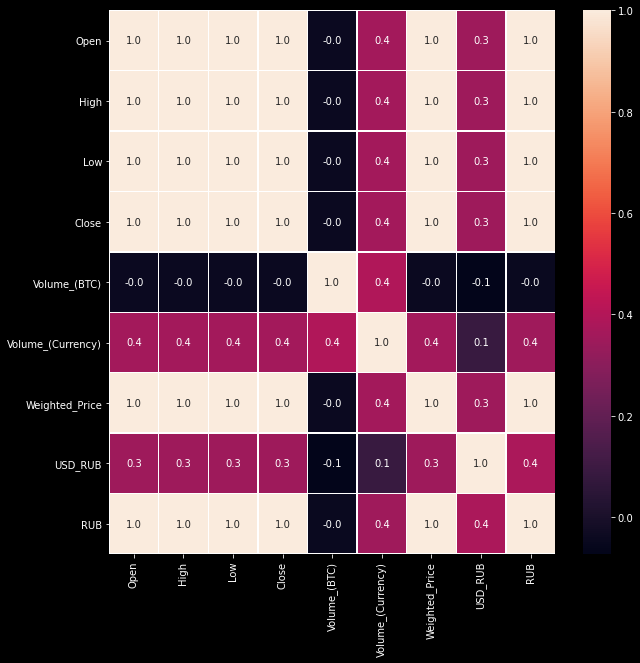

In [ ]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(all_btc.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

Можно посмотреть на график цены биткоина за все время:

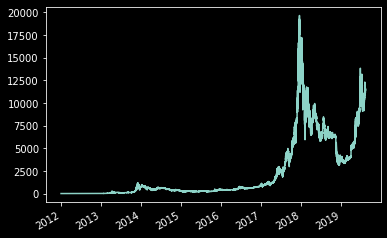

In [ ]:
all_btc.Weighted_Price.plot()

Зависимость объема от цены за этот объем:

Text(0.5, 1.0, 'BTC-Currency Scatter Plot')

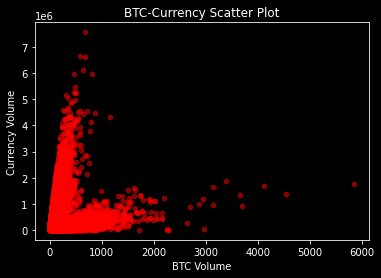

In [ ]:
all_btc.plot(kind='scatter', x='Volume_(BTC)', y='Volume_(Currency)',alpha = 0.5, color = 'red')
plt.xlabel('BTC Volume')              # label = name of label
plt.ylabel('Currency Volume')
plt.title('BTC-Currency Scatter Plot')  

Отобразим зависимость объемов продаж от цены биткоина:

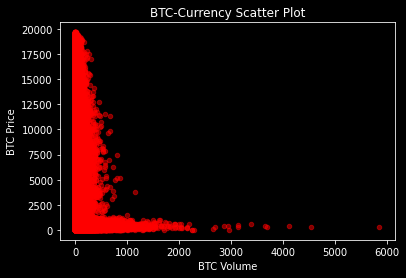

In [ ]:
all_btc.plot(kind='scatter', x='Volume_(BTC)', y='Weighted_Price', alpha = 0.5, color = 'red')
plt.xlabel('BTC Volume')              # label = name of label
plt.ylabel('BTC Price')
plt.title('BTC-Currency Scatter Plot')  
plt.show()

Выберем данные за 2019 год и посмотрим, в каких объемах покупали биткоины по каким ценам.

In [ ]:
BTC_2019 = all_btc[all_btc.index >= datetime.datetime(2019, 1, 1)]
BTC_2019.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,USD_RUB,RUB
2019-01-01 00:00:00,3693.850,3698.790,3693.850,3698.000,5.491,20301.157,3696.975,69.327,256300.551
2019-01-01 00:01:00,3694.720,3694.720,3690.650,3690.650,9.500,35080.266,3692.601,69.338,256037.559
2019-01-01 00:02:00,3689.730,3689.730,3686.620,3686.620,0.966,3562.371,3687.885,69.272,255467.886
2019-01-01 00:03:00,3692.850,3692.850,3688.320,3692.350,0.297,1095.221,3691.813,69.290,255806.850
2019-01-01 00:04:00,3692.350,3692.350,3690.340,3690.340,0.112,412.065,3691.615,69.290,255792.362


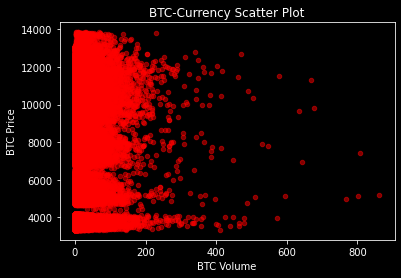

In [ ]:
BTC_2019.plot(kind='scatter', x='Volume_(BTC)', y='Weighted_Price', alpha = 0.5, color = 'red')
plt.xlabel('BTC Volume')              # label = name of label
plt.ylabel('BTC Price')
plt.title('BTC-Currency Scatter Plot')  
plt.show()

Вне зависимости от цены биткоины по большей части покупают маленькими объемами.

В каких годах люди покупали биткоин большими объемами:

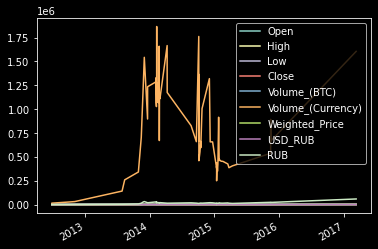

In [ ]:
all_btc[all_btc['Volume_(BTC)']>1500].plot()

Гистограмма по ценам открытия:

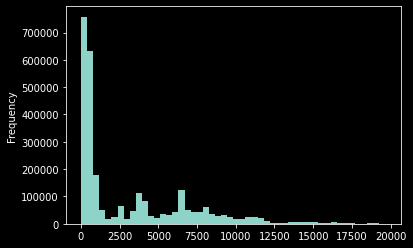

In [ ]:
all_btc.Open.plot(kind='hist', bins=50)

Самая большая разница в цене в течение минуты:

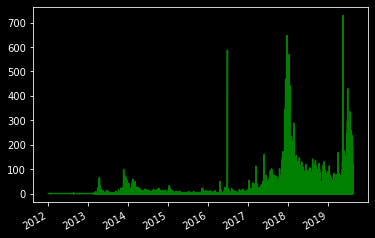

In [ ]:
(all_btc.High - all_btc.Low).plot(color='green')

Интересный случай, за минуту разница 700 долларов, давайте посмотрим внимательнее:

In [ ]:
all_btc[(all_btc.High - all_btc.Low)>700]

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,USD_RUB,RUB
2019-05-17 03:10:00,6250.000,6907.010,6178.000,6907.010,150.971,940847.083,6231.966,64.592,402537.020


In [ ]:
all_btc.loc['2019-05-17 03:00:00':'2019-05-17 03:15:00', :]

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,USD_RUB,RUB
2019-05-17 03:00:00,7318.000,7318.000,7148.000,7148.000,385.747,2785189.151,7220.249,64.599,466419.399
2019-05-17 03:01:00,7147.000,7147.000,7100.020,7100.020,296.733,2108866.758,7106.941,64.603,459132.524
2019-05-17 03:02:00,7100.020,7100.020,7001.000,7001.000,448.353,3152032.649,7030.249,64.588,454069.736
2019-05-17 03:03:00,7001.000,7001.000,6844.440,6844.440,643.799,4457442.647,6923.657,64.612,447354.814
2019-05-17 03:04:00,6843.350,6843.350,6718.000,6718.000,213.999,1452791.035,6788.764,64.612,438639.018
2019-05-17 03:05:00,6718.000,6718.000,6606.000,6606.000,225.033,1500593.171,6668.329,64.616,430880.759
2019-05-17 03:06:00,6606.000,6606.000,6493.770,6493.770,338.266,2212210.056,6539.854,64.594,422438.598
2019-05-17 03:07:00,6492.000,6492.000,6420.000,6420.000,289.972,1874226.833,6463.466,64.592,417490.146
2019-05-17 03:08:00,6420.000,6420.000,6350.030,6350.030,185.181,1182485.622,6385.575,64.598,412492.788
2019-05-17 03:09:00,6350.000,6350.000,6250.000,6250.000,262.538,1654015.913,6300.090,64.592,406937.910


Начиная с 3:10 биткоин резко подорожал, после чего цена стала восстанавливаться к предыдущему значению очень медленно.

Как менялся курс доллара с течением времени:

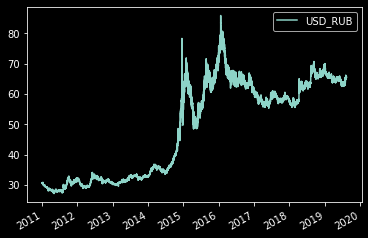

In [ ]:
usd_rub.plot()

И, наконец, посмотрим зависимость цены доллара от стоимости биткоина:

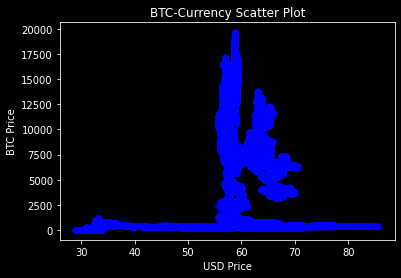

In [ ]:
all_btc.plot(kind='scatter', x='USD_RUB', y='Weighted_Price', alpha = 0.5, color = 'blue')
plt.xlabel('USD Price')              # label = name of label
plt.ylabel('BTC Price')
plt.title('BTC-Currency Scatter Plot')  
plt.show()

Биткоин набрал большую популярность в 2017, когда доллар был по 60-70р.

Выполним таже дополнительный анализ:
2. Скачаем актуальные данные с того же сайта до 06.2020. Дорисуем все статистики и графики для добавленных данных.
3. Посмотрим, сколько стоил биткоин, когда доллар имел максимальную цену;
4. Нарисуем график изменения цены доллара за 2019 год;
5. Отобразим на графике разницу между ценами открытия и закрытия. Определим когда она была максимальной.

2. Скачаем актуальные данные с того же сайта до 06.2020. Дорисуем все статистики и графики для добавленных данных.

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# https://drive.google.com/file/d/1yCsy4tNT3Ti9WP7ucWvTnBFBPZavMDPA/view?usp=sharing
BTC_USD = "1yCsy4tNT3Ti9WP7ucWvTnBFBPZavMDPA"

BTC_USD_file = drive.CreateFile({'id': BTC_USD }) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(BTC_USD_file['title'])  
BTC_USD_file.GetContentFile(BTC_USD_file['title'])  # Save Drive file as a local file

Bitcoin_Historical_Data.zip


In [ ]:
!unzip {BTC_USD_file['title']}

Archive:  Bitcoin_Historical_Data.zip
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv  


In [ ]:
# https://drive.google.com/file/d/1aFHULXfzRmGHMp0ZgwXn98mmtcQVgMIB/view?usp=sharing
USD_RUB = '1aFHULXfzRmGHMp0ZgwXn98mmtcQVgMIB'
USD_RUB_file = drive.CreateFile({'id': USD_RUB }) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(USD_RUB_file['title'])  
USD_RUB_file.GetContentFile(USD_RUB_file['title'])  # Save Drive file as a local file

RUB_USD.zip


In [ ]:
!unzip {USD_RUB_file['title']}

Archive:  RUB_USD.zip
  inflating: RC_F21_03_2000_T21_03_2020.xlsx  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

plt.style.use('dark_background')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
btc = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
btc

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.390,4.390,4.390,4.390,0.456,2.000,4.390
1,1325317980,nan,nan,nan,nan,nan,nan,nan
2,1325318040,nan,nan,nan,nan,nan,nan,nan
3,1325318100,nan,nan,nan,nan,nan,nan,nan
4,1325318160,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.310,58714.310,58686.000,58686.000,1.384,81259.372,58692.753
4857373,1617148620,58683.970,58693.430,58683.970,58685.810,7.295,428158.147,58693.227
4857374,1617148680,58693.430,58723.840,58693.430,58723.840,1.706,100117.070,58696.198
4857375,1617148740,58742.180,58770.380,58742.180,58760.590,0.720,42332.959,58761.866


In [ ]:
#Вывод: данных очень много.
#Приведем к читаемому виду Timestamp:

In [ ]:
btc.index = btc['Timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
del btc['Timestamp']
btc.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.390,4.390,4.390,4.390,0.456,2.000,4.390
2011-12-31 07:53:00,nan,nan,nan,nan,nan,nan,nan
2011-12-31 07:54:00,nan,nan,nan,nan,nan,nan,nan
2011-12-31 07:55:00,nan,nan,nan,nan,nan,nan,nan
2011-12-31 07:56:00,nan,nan,nan,nan,nan,nan,nan


In [ ]:
btc.dropna(inplace=True) #удалим все значения NAN
btc

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.390,4.390,4.390,4.390,0.456,2.000,4.390
2011-12-31 15:50:00,4.390,4.390,4.390,4.390,48.000,210.720,4.390
2011-12-31 16:59:00,4.500,4.570,4.500,4.570,37.862,171.380,4.526
2011-12-31 17:00:00,4.580,4.580,4.580,4.580,9.000,41.220,4.580
2012-01-01 04:16:00,4.580,4.580,4.580,4.580,1.502,6.879,4.580
...,...,...,...,...,...,...,...
2021-03-30 23:56:00,58714.310,58714.310,58686.000,58686.000,1.384,81259.372,58692.753
2021-03-30 23:57:00,58683.970,58693.430,58683.970,58685.810,7.295,428158.147,58693.227
2021-03-30 23:58:00,58693.430,58723.840,58693.430,58723.840,1.706,100117.070,58696.198


In [ ]:
btc = btc['2011-12-31 00:00:00':'2020-03-21 00:00:00'] #получаем срез данных в пределах - начальный timestamp таблицы btc : конечный timestamp таблицы usd_rub

In [ ]:
btc.describe()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3081631.000,3081631.000,3081631.000,3081631.000,3081631.000,3081631.000,3081631.000
mean,3629.913,3632.599,3627.009,3629.852,9.892,28548.955,3629.824
std,3946.214,3949.736,3942.320,3946.125,32.438,100501.169,3946.089
min,3.800,3.800,1.500,1.500,0.000,0.000,3.800
25%,404.490,404.830,404.030,404.500,0.398,342.731,404.470
50%,1081.950,1083.000,1080.900,1082.000,1.986,2543.187,1081.847
75%,6915.000,6919.400,6910.260,6914.870,7.655,17176.868,6914.741
max,19665.760,19666.000,19649.960,19665.750,5853.852,7569437.061,19663.299


Отсюда понимаем, что максимальная цена биткоина была 61763.56 долларов, а минимальная - 3.8 долларов. Медиана - 3596.97 долларов.

In [ ]:
btc['High'].max() #то же, но через Series

19666.0

In [ ]:
btc['High'].median() #то же, но через Series

1083.0

In [ ]:
btc.min() 

Open                3.800
High                3.800
Low                 1.500
Close               1.500
Volume_(BTC)        0.000
Volume_(Currency)   0.000
Weighted_Price      3.800
dtype: float64

In [ ]:
btc.corr() #посмотрим корреляцию

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Open,1.000,1.000,1.000,1.000,-0.057,0.315,1.000
High,1.000,1.000,1.000,1.000,-0.057,0.315,1.000
Low,1.000,1.000,1.000,1.000,-0.058,0.314,1.000
Close,1.000,1.000,1.000,1.000,-0.057,0.315,1.000
Volume_(BTC),-0.057,-0.057,-0.058,-0.057,1.000,0.417,-0.057
Volume_(Currency),0.315,0.315,0.314,0.315,0.417,1.000,0.315
Weighted_Price,1.000,1.000,1.000,1.000,-0.057,0.315,1.000


In [ ]:
btc[btc['Weighted_Price']>2000].head()     # Выберем строки, где общая цена покупки более $2000

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2017-05-20 22:59:00,2000.000,2004.000,1999.600,1999.600,205.157,410349.574,2000.170
2017-05-20 23:00:00,2004.000,2008.000,2001.990,2005.450,22.815,45752.828,2005.394
2017-05-20 23:01:00,2007.000,2010.000,2005.450,2010.000,21.909,43993.707,2008.031
2017-05-20 23:02:00,2008.950,2014.300,2004.970,2004.970,28.773,57857.905,2010.814
2017-05-20 23:03:00,2004.970,2014.560,2004.970,2007.400,37.454,75402.027,2013.169


Теперь работаем с таблицей курса Рубль-Доллар:

In [ ]:
#читаем, удаляем дубликаты
usd_rub = pd.read_excel('RC_F21_03_2000_T21_03_2020.xlsx')
usd_rub.drop_duplicates(inplace=True)
usd_rub

,nominal,data,curs,cdx
0,1,2000-03-21,28.390,Доллар США
1,1,2000-03-22,28.380,Доллар США
2,1,2000-03-23,28.360,Доллар США
3,1,2000-03-24,28.340,Доллар США
4,1,2000-03-25,28.330,Доллар США
...,...,...,...,...
4963,1,2020-03-17,74.126,Доллар США
4964,1,2020-03-18,73.890,Доллар США
4965,1,2020-03-19,77.213,Доллар США
4966,1,2020-03-20,80.157,Доллар США


In [ ]:
usd_rub['nominal'].describe()

count   4968.000
mean       1.000
std        0.000
min        1.000
25%        1.000
50%        1.000
75%        1.000
max        1.000
Name: nominal, dtype: float64

In [ ]:
usd_rub = usd_rub[['data','curs']] #оставляем информативные столбцы

In [ ]:
usd_rub.index = usd_rub['data'] #определяем timestamp в качестве index
del usd_rub['data']

In [ ]:
usd_rub

,curs
data,
2000-03-21,28.390
2000-03-22,28.380
2000-03-23,28.360
2000-03-24,28.340
2000-03-25,28.330
...,...
2020-03-17,74.126
2020-03-18,73.890
2020-03-19,77.213


In [ ]:
# btc = btc['2011-12-31 00:00:00':'2020-03-21 00:00:00']
usd_rub = usd_rub['2011-12-31 00:00:00':'2020-03-21 00:00:00']  #получаем срез данных в пределах - начальный timestamp таблицы btc : конечный timestamp таблицы usd_rub

In [ ]:
usd_rub 

,curs
data,
2011-12-31,32.196
2012-01-11,31.873
2012-01-12,31.689
2012-01-13,31.681
2012-01-14,31.583
...,...
2020-03-17,74.126
2020-03-18,73.890
2020-03-19,77.213


In [ ]:
all_dates = pd.DataFrame(columns=['N'],index=pd.date_range(start='31/12/2011', end='21/03/2020', freq='min')) #создаем новый DataFrame с нужными timestamp
all_dates

,N
2011-12-31 00:00:00,NaN
2011-12-31 00:01:00,NaN
2011-12-31 00:02:00,NaN
2011-12-31 00:03:00,NaN
2011-12-31 00:04:00,NaN
...,...
2020-03-20 23:56:00,NaN
2020-03-20 23:57:00,NaN
2020-03-20 23:58:00,NaN
2020-03-20 23:59:00,NaN


In [ ]:
usd_rub = pd.concat([usd_rub, all_dates], axis=1) #объединяем две таблицы

In [ ]:
del usd_rub['N'] #удаляем ненужный столбец

In [ ]:
usd_rub.fillna(method='ffill', inplace=True) #продлеваем значения вышестоящего курса рубль-доллар ниже на все NAN, пока не встретится следующее значение

In [ ]:
usd_rub

,curs
2011-12-31 00:00:00,32.196
2011-12-31 00:01:00,32.196
2011-12-31 00:02:00,32.196
2011-12-31 00:03:00,32.196
2011-12-31 00:04:00,32.196
...,...
2020-03-20 23:56:00,80.157
2020-03-20 23:57:00,80.157
2020-03-20 23:58:00,80.157
2020-03-20 23:59:00,80.157


Курс доллара к рублю заполнен. Объединим эту таблицу с информацией по биткоину:

In [ ]:
all_btc = pd.concat([btc, usd_rub], axis=1, join='inner')

In [ ]:
all_btc

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,curs
2011-12-31 07:52:00,4.390,4.390,4.390,4.390,0.456,2.000,4.390,32.196
2011-12-31 15:50:00,4.390,4.390,4.390,4.390,48.000,210.720,4.390,32.196
2011-12-31 16:59:00,4.500,4.570,4.500,4.570,37.862,171.380,4.526,32.196
2011-12-31 17:00:00,4.580,4.580,4.580,4.580,9.000,41.220,4.580,32.196
2012-01-01 04:16:00,4.580,4.580,4.580,4.580,1.502,6.879,4.580,32.196
...,...,...,...,...,...,...,...,...
2020-03-20 23:55:00,6189.650,6211.540,6189.650,6207.140,0.528,3278.832,6207.342,80.157
2020-03-20 23:57:00,6214.060,6236.450,6212.770,6224.460,20.182,125560.106,6221.418,80.157
2020-03-20 23:58:00,6231.220,6231.220,6219.190,6231.210,0.911,5675.120,6229.148,80.157
2020-03-20 23:59:00,6223.780,6230.790,6196.390,6210.140,2.493,15485.019,6212.161,80.157


Теперь создадим новый столбец, в котором будет записана цена биткоина в рублях:

In [ ]:
all_btc['RUB'] = all_btc['curs'] * all_btc['Weighted_Price']

In [ ]:
all_btc

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,curs,RUB
2011-12-31 07:52:00,4.390,4.390,4.390,4.390,0.456,2.000,4.390,32.196,141.341
2011-12-31 15:50:00,4.390,4.390,4.390,4.390,48.000,210.720,4.390,32.196,141.341
2011-12-31 16:59:00,4.500,4.570,4.500,4.570,37.862,171.380,4.526,32.196,145.733
2011-12-31 17:00:00,4.580,4.580,4.580,4.580,9.000,41.220,4.580,32.196,147.458
2012-01-01 04:16:00,4.580,4.580,4.580,4.580,1.502,6.879,4.580,32.196,147.458
...,...,...,...,...,...,...,...,...,...
2020-03-20 23:55:00,6189.650,6211.540,6189.650,6207.140,0.528,3278.832,6207.342,80.157,497561.906
2020-03-20 23:57:00,6214.060,6236.450,6212.770,6224.460,20.182,125560.106,6221.418,80.157,498690.185
2020-03-20 23:58:00,6231.220,6231.220,6219.190,6231.210,0.911,5675.120,6229.148,80.157,499309.794
2020-03-20 23:59:00,6223.780,6230.790,6196.390,6210.140,2.493,15485.019,6212.161,80.157,497948.165


Посмотрим статистику по рублю:

In [ ]:
all_btc['RUB'].describe()

count   3081631.000
mean     223862.472
std      245730.027
min         115.368
25%       18555.105
50%       61775.963
75%      439858.614
max     1158142.742
Name: RUB, dtype: float64

In [ ]:
all_btc[all_btc['Weighted_Price']>17000]

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,curs,RUB
2017-12-11 20:16:00,17000.000,17027.260,16998.000,17027.260,94.806,1612087.556,17004.138,59.281,1008023.982
2017-12-11 20:17:00,17027.260,17119.090,17027.250,17100.000,42.208,720191.618,17062.726,59.281,1011497.152
2017-12-11 20:18:00,17100.260,17115.000,17076.970,17100.000,60.073,1027302.405,17100.888,59.281,1013759.460
2017-12-11 20:19:00,17100.000,17110.000,17100.000,17110.000,18.549,317354.936,17108.677,59.281,1014221.191
2017-12-11 20:20:00,17110.000,17119.090,17100.240,17119.090,29.968,512855.446,17113.338,59.281,1014497.505
...,...,...,...,...,...,...,...,...,...
2018-01-07 01:56:00,17014.000,17031.260,16976.820,17019.010,1.521,25890.678,17020.210,57.600,980367.501
2018-01-07 01:57:00,17029.800,17029.990,17019.010,17027.790,2.795,47590.307,17027.966,57.600,980814.244
2018-01-07 01:58:00,17020.010,17027.790,17020.010,17027.790,1.052,17905.336,17026.442,57.600,980726.439
2018-01-07 01:59:00,17024.790,17030.000,17024.790,17027.750,3.115,53048.750,17028.074,57.600,980820.445


Минимальная цена за всю историю была 115.36 рублей, максимальная - 1.158 млн.

Последние имеющиеся данные за март-2021 показывают, что биткоин продавался за 484826.09 тыс.р.:

In [ ]:
all_btc.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,curs,RUB
2020-03-20 23:55:00,6189.650,6211.540,6189.650,6207.140,0.528,3278.832,6207.342,80.157,497561.906
2020-03-20 23:57:00,6214.060,6236.450,6212.770,6224.460,20.182,125560.106,6221.418,80.157,498690.185
2020-03-20 23:58:00,6231.220,6231.220,6219.190,6231.210,0.911,5675.120,6229.148,80.157,499309.794
2020-03-20 23:59:00,6223.780,6230.790,6196.390,6210.140,2.493,15485.019,6212.161,80.157,497948.165
2020-03-21 00:00:00,6207.660,6227.310,6203.990,6220.440,0.825,5124.404,6212.191,78.044,484826.091


Корреляция, которая была дана в табличном виде можно отобразить на графике:

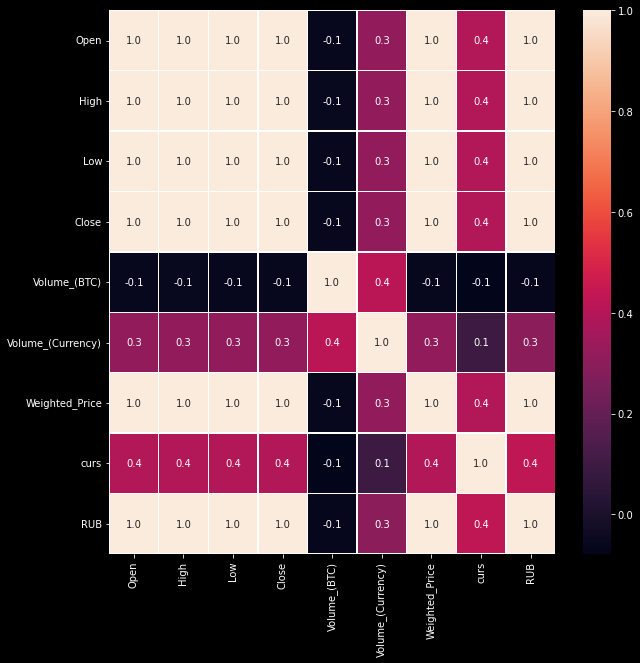

In [ ]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(all_btc.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

Можно посмотреть на график цены биткоина за все время:

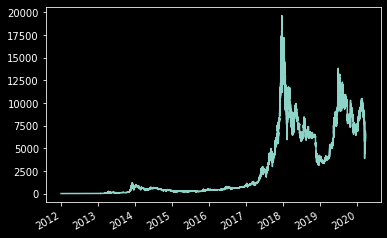

In [ ]:
all_btc.Weighted_Price.plot()

Зависимость объема от цены за этот объем:

Text(0.5, 1.0, 'BTC-Currency Scatter Plot')

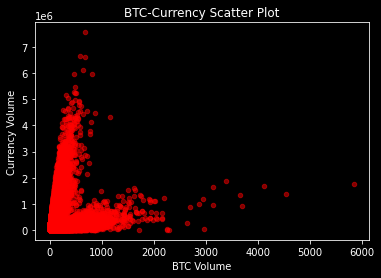

In [ ]:
all_btc.plot(kind='scatter', x='Volume_(BTC)', y='Volume_(Currency)',alpha = 0.5, color = 'red')
plt.xlabel('BTC Volume')              # label = name of label
plt.ylabel('Currency Volume')
plt.title('BTC-Currency Scatter Plot')  

Отобразим зависимость объемов продаж от цены биткоина:

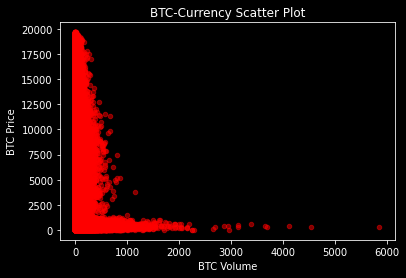

In [ ]:
all_btc.plot(kind='scatter', x='Volume_(BTC)', y='Weighted_Price', alpha = 0.5, color = 'red')
plt.xlabel('BTC Volume')              # label = name of label
plt.ylabel('BTC Price')
plt.title('BTC-Currency Scatter Plot')  
plt.show()

Выберем данные за 2019 год и посмотрим, в каких объемах покупали биткоины по каким ценам.

In [ ]:
BTC_2019 = all_btc[all_btc.index >= datetime.datetime(2019, 1, 1)]
BTC_2019.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,curs,RUB
2019-01-01 00:00:00,3693.850,3698.790,3693.850,3698.000,5.491,20301.157,3696.975,69.471,256831.067
2019-01-01 00:01:00,3694.720,3694.720,3690.650,3690.650,9.500,35080.266,3692.601,69.471,256527.198
2019-01-01 00:02:00,3689.730,3689.730,3686.620,3686.620,0.966,3562.371,3687.885,69.471,256199.563
2019-01-01 00:03:00,3692.850,3692.850,3688.320,3692.350,0.297,1095.221,3691.813,69.471,256472.484
2019-01-01 00:04:00,3692.350,3692.350,3690.340,3690.340,0.112,412.065,3691.615,69.471,256458.699


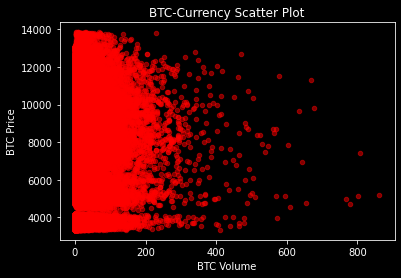

In [ ]:
BTC_2019.plot(kind='scatter', x='Volume_(BTC)', y='Weighted_Price', alpha = 0.5, color = 'red')
plt.xlabel('BTC Volume')              # label = name of label
plt.ylabel('BTC Price')
plt.title('BTC-Currency Scatter Plot')  
plt.show()

Вне зависимости от цены биткоины по большей части покупают маленькими объемами.

А в каких годах люди покупали биткоин большими объемами?

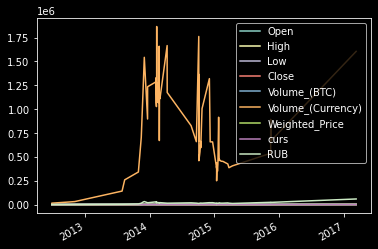

In [ ]:
all_btc[all_btc['Volume_(BTC)']>1500].plot()

Гистограмма по ценам открытия:

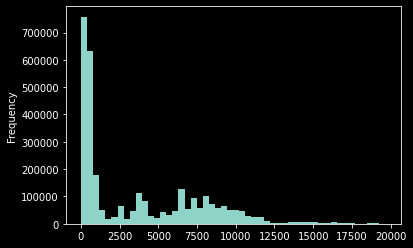

In [ ]:
all_btc.Open.plot(kind='hist', bins=50)

Самая большая разница в цене в течение минуты:

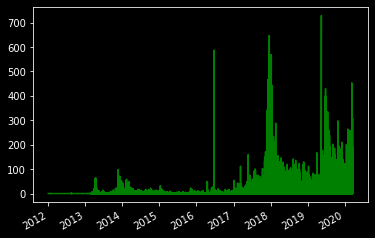

In [ ]:
(all_btc.High - all_btc.Low).plot(color='green')

За минуту разница 700 долларов, давайте посмотрим внимательнее:

In [ ]:
all_btc[(all_btc.High - all_btc.Low)>700]

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,curs,RUB
2019-05-17 03:10:00,6250.000,6907.010,6178.000,6907.010,150.971,940847.083,6231.966,64.560,402334.481


In [ ]:
all_btc.loc['2019-05-17 03:00:00':'2019-05-17 03:15:00', :]

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,curs,RUB
2019-05-17 03:00:00,7318.000,7318.000,7148.000,7148.000,385.747,2785189.151,7220.249,64.560,466137.809
2019-05-17 03:01:00,7147.000,7147.000,7100.020,7100.020,296.733,2108866.758,7106.941,64.560,458822.661
2019-05-17 03:02:00,7100.020,7100.020,7001.000,7001.000,448.353,3152032.649,7030.249,64.560,453871.483
2019-05-17 03:03:00,7001.000,7001.000,6844.440,6844.440,643.799,4457442.647,6923.657,64.560,446989.937
2019-05-17 03:04:00,6843.350,6843.350,6718.000,6718.000,213.999,1452791.035,6788.764,64.560,438281.250
2019-05-17 03:05:00,6718.000,6718.000,6606.000,6606.000,225.033,1500593.171,6668.329,64.560,430505.999
2019-05-17 03:06:00,6606.000,6606.000,6493.770,6493.770,338.266,2212210.056,6539.854,64.560,422211.665
2019-05-17 03:07:00,6492.000,6492.000,6420.000,6420.000,289.972,1874226.833,6463.466,64.560,417280.084
2019-05-17 03:08:00,6420.000,6420.000,6350.030,6350.030,185.181,1182485.622,6385.575,64.560,412251.413
2019-05-17 03:09:00,6350.000,6350.000,6250.000,6250.000,262.538,1654015.913,6300.090,64.560,406732.527


Начиная с 3:10 биткоин резко подорожал, после чего цена стала восстанавливаться к предыдущему значению очень медленно.

Как менялся курс доллара с течением времени:

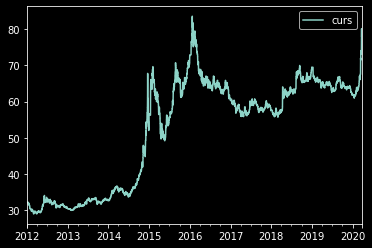

In [ ]:
usd_rub.plot()

И, наконец, посмотрим зависимость цены доллара от стоимости биткоина:

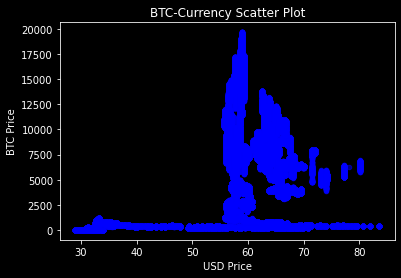

In [ ]:
all_btc.plot(kind='scatter', x='curs', y='Weighted_Price', alpha = 0.5, color = 'blue')
plt.xlabel('USD Price')              # label = name of label
plt.ylabel('BTC Price')
plt.title('BTC-Currency Scatter Plot')  
plt.show()

Биткоин набрал большую популярность в 2017, когда доллар был по 60-70р.

3. Определим, сколько стоил биткоин, когда доллар имел максимальную цену:

In [ ]:
all_btc

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,curs,RUB
2011-12-31 07:52:00,4.390,4.390,4.390,4.390,0.456,2.000,4.390,32.196,141.341
2011-12-31 15:50:00,4.390,4.390,4.390,4.390,48.000,210.720,4.390,32.196,141.341
2011-12-31 16:59:00,4.500,4.570,4.500,4.570,37.862,171.380,4.526,32.196,145.733
2011-12-31 17:00:00,4.580,4.580,4.580,4.580,9.000,41.220,4.580,32.196,147.458
2012-01-01 04:16:00,4.580,4.580,4.580,4.580,1.502,6.879,4.580,32.196,147.458
...,...,...,...,...,...,...,...,...,...
2020-03-20 23:55:00,6189.650,6211.540,6189.650,6207.140,0.528,3278.832,6207.342,80.157,497561.906
2020-03-20 23:57:00,6214.060,6236.450,6212.770,6224.460,20.182,125560.106,6221.418,80.157,498690.185
2020-03-20 23:58:00,6231.220,6231.220,6219.190,6231.210,0.911,5675.120,6229.148,80.157,499309.794
2020-03-20 23:59:00,6223.780,6230.790,6196.390,6210.140,2.493,15485.019,6212.161,80.157,497948.165


In [ ]:
all_btc['curs'].max() #максимальная стоимость доллара в рублях

83.5913

In [ ]:
Weighted_Price_Btc = all_btc[all_btc['curs'] == all_btc['curs'].max()]
Weighted_Price_Btc

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,curs,RUB
2016-01-22 00:00:00,409.420,409.780,409.420,409.560,1.389,569.191,409.649,83.591,34243.070
2016-01-22 00:01:00,409.410,409.410,409.210,409.210,0.217,88.869,409.328,83.591,34216.230
2016-01-22 00:02:00,409.450,409.450,409.450,409.450,2.427,993.894,409.450,83.591,34226.458
2016-01-22 00:04:00,409.550,409.550,409.490,409.490,0.931,381.426,409.507,83.591,34231.197
2016-01-22 00:06:00,409.490,409.490,409.490,409.490,0.133,54.298,409.490,83.591,34229.801
...,...,...,...,...,...,...,...,...,...
2016-01-22 23:55:00,381.580,383.800,381.500,381.640,15.824,6072.230,383.733,83.591,32076.700
2016-01-22 23:56:00,382.920,383.980,381.700,383.110,16.123,6187.839,383.783,83.591,32080.925
2016-01-22 23:57:00,382.930,383.130,382.930,383.130,0.781,299.121,382.930,83.591,32009.641
2016-01-22 23:58:00,382.310,383.600,381.340,382.440,10.559,4040.359,382.649,83.591,31986.143


In [ ]:
Weighted_Price_Btc['Weighted_Price'].describe()

count   1212.000
mean     392.837
std        9.623
min      374.959
25%      383.481
50%      395.100
75%      398.489
max      409.940
Name: Weighted_Price, dtype: float64

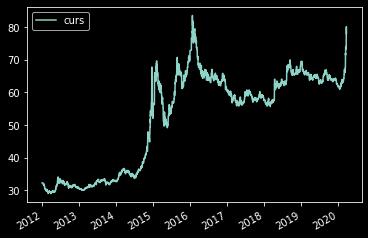

In [ ]:
all_btc.plot(y='curs')

Вывод: даллар имел максимальную стоимость в январе 2016 года равную 83.59 рублей. В этом же месяце минимальная стоимость биткоина равнялась 374.95 долларов, максимальная стоимость биткоина равнялась 409.94 долларов. 

4. Нарисуем график изменения цены доллара за 2019 год:

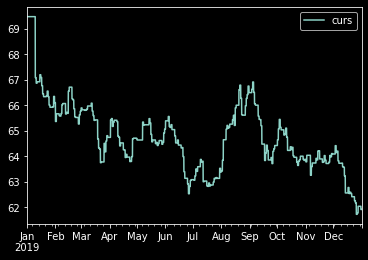

In [ ]:
usd_rub['2019-01-01 00:00:00':'2019-12-31 23:59:00'].plot()

Вывод: в течение 2019 года стоимость доллара по отношению к рублю снижалась.

5. Отобразим на графике разницу между ценами открытия и закрытия. Посмотрим когда она была максимальной:

In [ ]:
all_btc

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,curs,RUB
2011-12-31 07:52:00,4.390,4.390,4.390,4.390,0.456,2.000,4.390,32.196,141.341
2011-12-31 15:50:00,4.390,4.390,4.390,4.390,48.000,210.720,4.390,32.196,141.341
2011-12-31 16:59:00,4.500,4.570,4.500,4.570,37.862,171.380,4.526,32.196,145.733
2011-12-31 17:00:00,4.580,4.580,4.580,4.580,9.000,41.220,4.580,32.196,147.458
2012-01-01 04:16:00,4.580,4.580,4.580,4.580,1.502,6.879,4.580,32.196,147.458
...,...,...,...,...,...,...,...,...,...
2020-03-20 23:55:00,6189.650,6211.540,6189.650,6207.140,0.528,3278.832,6207.342,80.157,497561.906
2020-03-20 23:57:00,6214.060,6236.450,6212.770,6224.460,20.182,125560.106,6221.418,80.157,498690.185
2020-03-20 23:58:00,6231.220,6231.220,6219.190,6231.210,0.911,5675.120,6229.148,80.157,499309.794
2020-03-20 23:59:00,6223.780,6230.790,6196.390,6210.140,2.493,15485.019,6212.161,80.157,497948.165


In [ ]:
all_btc['Difference'] = all_btc['Close'] - all_btc['Open']

In [ ]:
all_btc['Difference'] = all_btc['Difference'].abs()

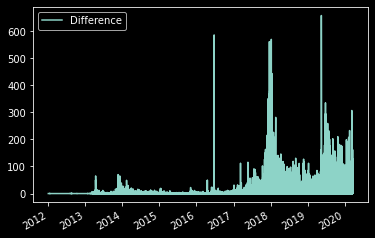

In [ ]:
all_btc.plot(y='Difference')

In [ ]:
all_btc['Difference'].describe()

count   3081631.000
mean          3.101
std           7.804
min           0.000
25%           0.000
50%           0.390
75%           2.930
max         657.010
Name: Difference, dtype: float64

In [ ]:
Difference_Df = all_btc[all_btc['Difference'] == all_btc['Difference'].max()]
Difference_Df

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,curs,RUB,Difference
2019-05-17 03:10:00,6250.000,6907.010,6178.000,6907.010,150.971,940847.083,6231.966,64.560,402334.481,657.010


Вывод: разница между ценами Btc открытия и закрытия была максимальной в 2019-05-17 03:10:00.